In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchdiffeq import odeint

from pideq.trainer import f
from pideq.net import PIDEQ
from pideq.utils import load_from_wandb

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [45]:
T = 2

net = load_from_wandb(PIDEQ(T, n_out=2, n_states=10), '1dkpskh0', model_fname='model_last').to(device)
net.eval

<bound method Module.eval of PIDEQ(
  (B): Linear(in_features=10, out_features=10, bias=True)
  (A): Linear(in_features=1, out_features=10, bias=True)
  (h): Linear(in_features=10, out_features=2, bias=True)
)>

In [6]:
K = 1000
dt = T / K
time = [dt * k for k in range(K+1)]

y0 = torch.Tensor([0., .1]).unsqueeze(0)

u = torch.Tensor([0.]).unsqueeze(0)

# y = odeint(lambda t, y: four_tanks(y,u), y0, torch.Tensor(time), method='rk4')
y = odeint(lambda t, y: f(y,u), y0, torch.Tensor([i * dt for i in range(K+1)]), method='rk4')
y = y.squeeze(1)
y.shape

torch.Size([1001, 2])

In [46]:
x = torch.Tensor(time).unsqueeze(-1).to(device)
# x.requires_grad_()
y_pred = net(x)[0]
# dy_pred_ = torch.autograd.grad(
#     y_pred_.sum(),
#     x
# )[0]

# y_pred = torch.stack([y_pred_, dy_pred_], dim=-1).squeeze(1)
y_pred.shape

torch.Size([1001, 2])

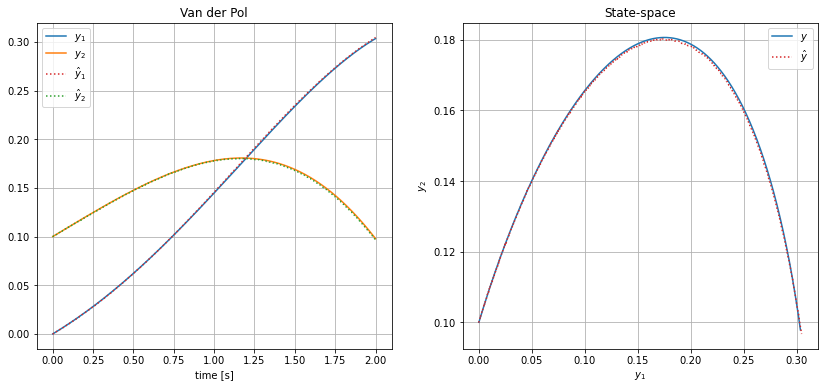

In [47]:
y_ = y.detach().numpy()
y_pred_ = y_pred.cpu().detach().numpy()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14,6)

axs[0].set_title('Van der Pol')
axs[0].plot(time, y_[:,0], c='tab:blue', label='$y_1$')
axs[0].plot(time, y_[:,1], c='tab:orange', label='$y_2$')
axs[0].plot(time, y_pred_[:,0], ':', c='tab:red', label='$\hat{y}_1$')
axs[0].plot(time, y_pred_[:,1], ':', c='tab:green', label='$\hat{y}_2$')
axs[0].set_xlabel('time [s]')
axs[0].legend()
axs[0].grid()

axs[1].set_title('State-space')
axs[1].plot(y_[:,0], y_[:,1], c='tab:blue', label='$y$')
axs[1].plot(y_pred_[:,0], y_pred_[:,1], ':', c='tab:red', label='$\hat{y}$')
# axs[1].plot(time, y_[:,3], label='$h_4$')
# axs[1].plot(time, y_pred_[:,2], '--', label='$h_3$')
# axs[1].plot(time, y_pred_[:,3], '--', label='$h_4$')
axs[1].set_ylabel('$y_2$')
axs[1].set_xlabel('$y_1$')
axs[1].legend()
axs[1].grid()

plt.show()

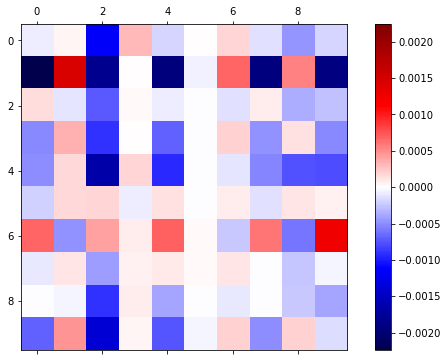

In [48]:
B = net.B.weight.detach().cpu().numpy()
A = net.A.weight.detach().cpu().numpy()

fig, ax = plt.subplots(1,1)

fig.set_size_inches(10,6)

l = max(-B.min(),B.max())
p = ax.matshow(B, cmap='seismic', vmin=-l, vmax=l)
fig.colorbar(p, ax=ax)

# axs[1].matshow(A, cmap='seismic', vmin=-l, vmax=l)

fig.show()

(array([4., 1., 2., 2., 0., 0., 0., 0., 0., 1.]),
 array([0.00114929, 0.00229153, 0.00343377, 0.00457601, 0.00571825,
        0.00686049, 0.00800273, 0.00914497, 0.0102872 , 0.01142944,
        0.01257169], dtype=float32),
 <BarContainer object of 10 artists>)

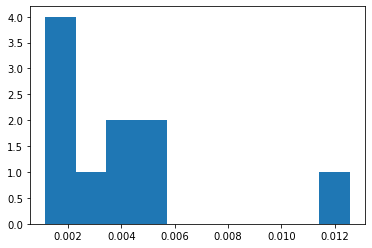

In [49]:
plt.hist(np.abs(B).sum(axis=1))